In [1]:
# IMPORTING MODULES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


In [2]:
# Reading Data

anime = pd.read_csv("archive/anime-dataset-2023.csv")

In [3]:
# Displaying Column metadata

print("ANIME DATA-")
anime.info()

ANIME DATA-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      24905 non-null  int64  
 1   Name          24905 non-null  object 
 2   English name  10328 non-null  object 
 3   Other name    24777 non-null  object 
 4   Score         15692 non-null  float64
 5   Genres        19976 non-null  object 
 6   Synopsis      24905 non-null  object 
 7   Type          24831 non-null  object 
 8   Episodes      24294 non-null  float64
 9   Aired         24905 non-null  object 
 10  Premiered     5506 non-null   object 
 11  Status        24905 non-null  object 
 12  Producers     11555 non-null  object 
 13  Licensors     4735 non-null   object 
 14  Studios       14379 non-null  object 
 15  Source        21216 non-null  object 
 16  Duration      24242 non-null  object 
 17  Rating        24236 non-null  object 
 18  Rank          

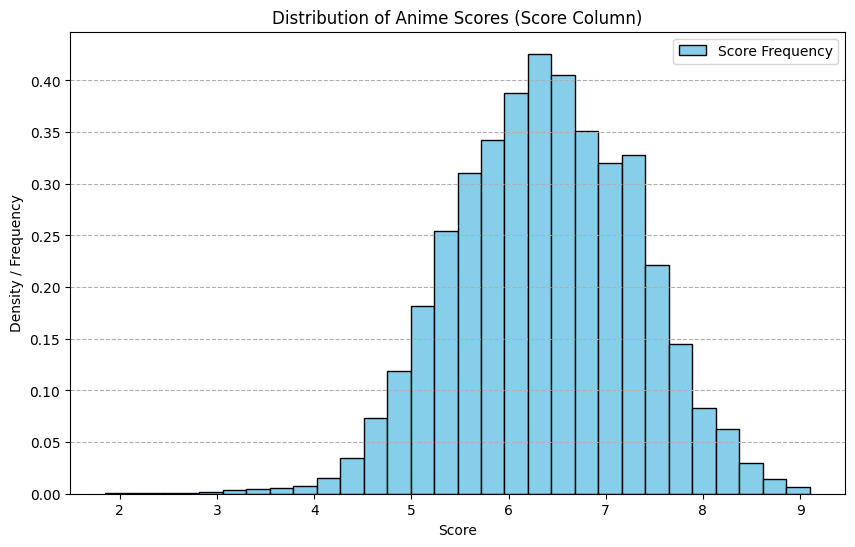

In [4]:
# Distribution of anime scores in database

plt.figure(figsize=(10, 6))
plt.hist(anime['Score'].dropna(), bins=30, color='skyblue', edgecolor='black', density=True, label='Score Frequency')
plt.title('Distribution of Anime Scores (Score Column)')
plt.xlabel('Score')
plt.ylabel('Density / Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

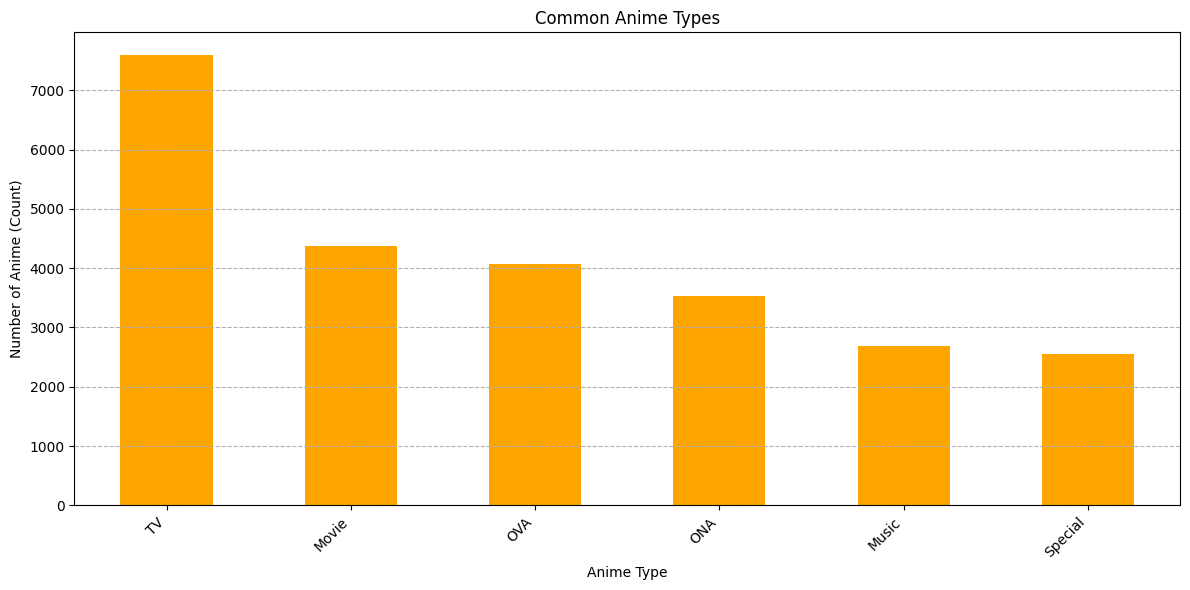

In [5]:
# Most common anime types in the database

plt.figure(figsize=(12, 6))

type_counts = anime['Type'].value_counts()

type_counts.plot(kind='bar', color='orange')

plt.title('Common Anime Types')
plt.xlabel('Anime Type')
plt.ylabel('Number of Anime (Count)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

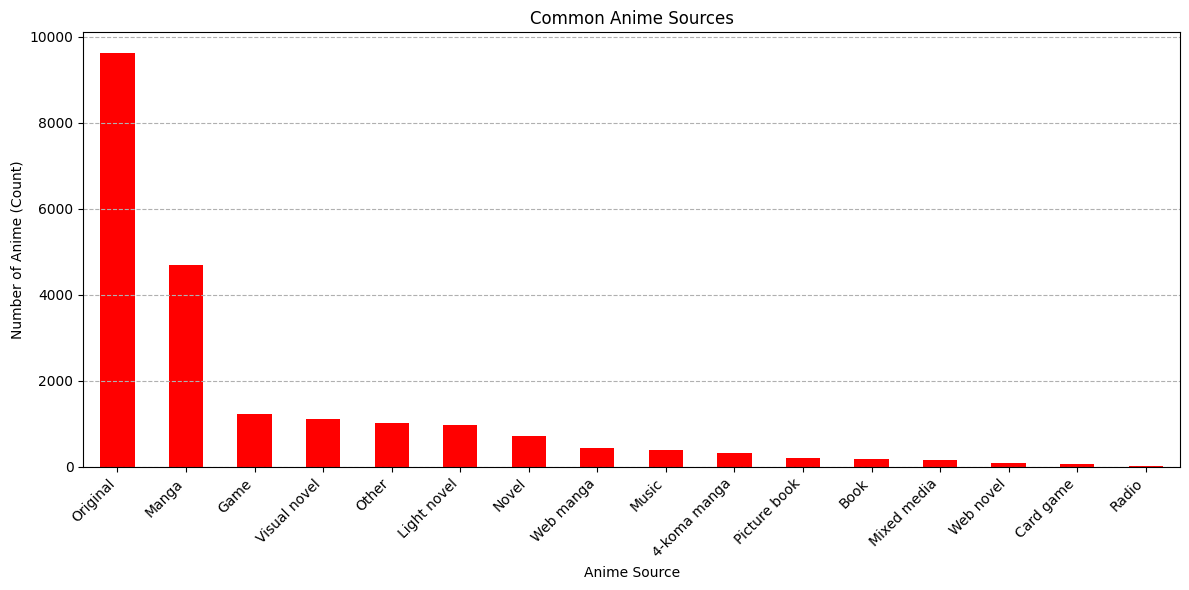

In [6]:
# Most common anime sources

plt.figure(figsize=(12, 6))

type_counts = anime['Source'].value_counts()

type_counts.plot(kind='bar', color='red')

plt.title('Common Anime Sources')
plt.xlabel('Anime Source')
plt.ylabel('Number of Anime (Count)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

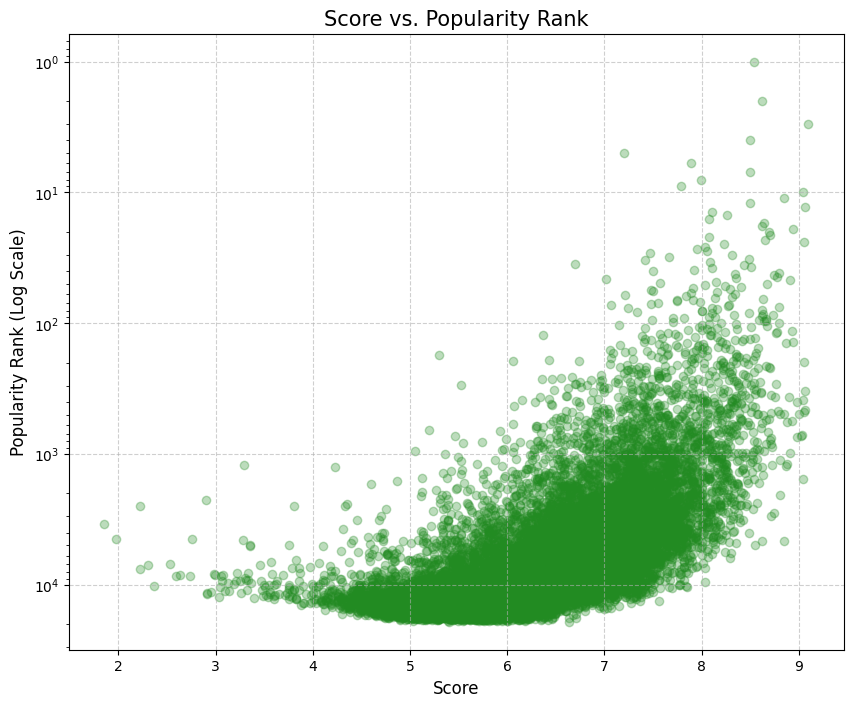

In [7]:
plt.figure(figsize=(10, 8))

plt.scatter(anime['Score'], anime['Popularity'], alpha=0.3, color='forestgreen')

plt.title('Score vs. Popularity Rank', fontsize=15)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Popularity Rank (Log Scale)', fontsize=12)

plt.yscale('log')
plt.gca().invert_yaxis()

plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [8]:
# Functions

def label_encode_column(series: pd.Series) -> tuple[pd.Series, dict]:
    """
    It creates a fixed dictionary where every string category is mapped to an integer ('TV' -> 0, 'Movie' -> 1, etc.).

    It returns the newly created integer column and the dictionary (the label_map)
    """    
    unique_values = series.unique()
    label_map = dict(zip(unique_values, range(len(unique_values))))
    encoded_series = series.map(label_map)
    encoded_series.astype('Int16')
    return encoded_series, {value: key for key, value in label_map.items()
}


def one_hot_encoding(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    It identifies every unique, explicit value in the column ('TV', 'Movie', 'OVA'). It ignores the shadows (NaN) for now.

    For each unique value found, it creates a new, dedicated binary column (e.g., Type_TV). It marks that column with a 1 only for rows 
    that possess that exact category, leaving all others as 0.

    After the categories are handled, it performs a final, critical step: it creates a dedicated [Column]_Missing flag. This flag marks 
    with a 1 every row where the original value was unknown (NaN), ensuring that the silence of the blank cell is not mistaken for a 
    definite 'Not Applicable' zero.
    """

    series = df[column_name]
    unique_values = series.dropna().unique()
    for i in unique_values:
        new_col_name = f"{column_name}_{i}"
        df[new_col_name] = (series == i).astype(np.int8)
        
    df[f"{column_name}_Missing"] = series.isnull().astype(np.int8)    
    return df

def multi_hot_encoding(df: pd.DataFrame, column_name: str, delimiter: str = ', ') -> pd.DataFrame:
    """
    It shatters the column (e.g., Genres) by the delimiter, identifying every unique attribute (e.g., 'Action', 'Comedy'). For each unique 
    attribute, it creates a new binary column (Genres_Action, Genres_Comedy).
    
    It sets the new column to 1 if the original row contained that specific attribute, and 0 if it did not.
    
    It explicitly traps any NaN or truly blank cells into a dedicated [Column]_Missing flag, preserving the vital information that the 
    original value was unknown.
    """
    
    series = df[column_name].fillna('')
    
    dummies = series.str.split(delimiter, expand=True) \
                .stack() \
                .str.strip() \
                .str.get_dummies() \
                .groupby(level=0).sum()
    
    # 3. Add the new columns to the original DataFrame
    dummies.columns = [f"{column_name}_{col.lower().replace(' ', '_')}" for col in dummies.columns]
    df = pd.concat([df, dummies.astype(np.int8)], axis=1)
    
    # 4. Add the Missing flag (if needed)
    df[f"{column_name}_Missing"] = df[column_name].isnull().astype(np.int8)
    
    return df


def duration_to_minutes(duration_str: str) -> float:
    """
    Converts strings like '1 hr 55 min' or '30 sec per ep' to a float of minutes.
    """
    if pd.isna(duration_str) or duration_str.strip() == '':
        return np.nan
    
    duration_str = str(duration_str).lower()
    total_minutes = 0.0

    matches = re.findall(r'(\d+)\s*(hr|min|sec)', duration_str)
    
    for value_str, unit in matches:
        value = float(value_str)
        if 'hr' in unit:
            total_minutes += value * 60 
        elif 'min' in unit:
            total_minutes += value
        elif 'sec' in unit:
            total_minutes += value / 60
            
    return round(total_minutes)


def Lammatize_synopsis(series: pd.Series) -> pd.Series:
    """
    1. Lowercasing and Punctuation Removal (TRANSLATOR).
    2. Tokenization and Stop Word Removal (Sifting).
    3. Lemmatization (Unification).
    """
    
    series = series.fillna('')

    def foo(text: str) -> str:
        text_processed = text.lower().translate(TRANSLATOR)
        tokens = text_processed.split()
        sifted_tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) > 1]
        unified_tokens = [LEMMATIZER.lemmatize(word) for word in sifted_tokens]
        return " ".join(unified_tokens)
        
    return series.apply(foo)


In [9]:
# Preprocessing the column data

''' Changing anime_id from int64 to int 32'''
anime['anime_id'] = anime['anime_id'].astype('int32')

''' Changing Score from float64 to float32 datatype'''
anime["Score"] = anime["Score"].astype('float32')

''' Changing Episodes from int64 to int16'''
anime['Episodes'] = anime['Episodes'].astype('Int16')

''' Splitting the Aired column to start date and end date'''
split_dates = anime['Aired'].str.split(' to ', expand=True)
anime['Start'] = split_dates[0]
anime['End'] = split_dates[1]
anime['Start'] = pd.to_datetime(anime['Start'], format='%b %d, %Y', errors='coerce')
anime['End'] = pd.to_datetime(anime['End'], format='%b %d, %Y', errors='coerce')

''' Label Encoding the Status of anime'''
anime['Status'] , animeStatusMap = label_encode_column(anime['Status'])

'''multi hot encode on genre'''
anime = multi_hot_encoding(anime, 'Genres')

'''one hot encoding the producers'''
anime = multi_hot_encoding(anime, 'Producers', ',')

'''multi hot encoding on Licensors'''
anime = multi_hot_encoding(anime, 'Licensors', ',')

'''multi hot encoding on Studio'''
anime = multi_hot_encoding(anime, 'Studios', ',')

'''one hot encoding on rating'''
anime = one_hot_encoding(anime, 'Rating')

'''one hot encodig on type'''
anime = one_hot_encoding(anime, 'Type')

'''introducing a watchtime column (number of episodes * Duration)'''
anime['Watchtime'] = anime['Duration'].apply(duration_to_minutes) * anime['Episodes']

In [10]:
anime.drop(columns='Aired', inplace=True)         # Split
anime.drop(columns='Status', inplace=True)        # Label Encoded
anime.drop(columns='Producers', inplace=True)     # Multi hot encoded
anime.drop(columns='Licensors', inplace=True)     # Multi hot encoded
anime.drop(columns='Studios', inplace=True)       # Multi hot encoded
anime.drop(columns='Type', inplace=True)          # One hot encoded
anime.drop(columns='Duration', inplace=True)      # Converted to watchtime
anime.drop(columns='Episodes', inplace=True)      # Converted to watch time
anime.drop(columns='Genres', inplace=True)        # Multi hot encoded
anime.drop(columns='Image URL', inplace=True)     # Redundant data
anime.drop(columns='Premiered', inplace=True)     # Redundant data
anime.drop(columns='Name', inplace=True)          # Redundant data
anime.drop(columns='English name', inplace=True)  # Redundant data
anime.drop(columns='Other name', inplace=True)    # Redundant data
anime.drop(columns='Rating', inplace=True)        # Multi hot encoded
anime.drop(columns='Source', inplace=True)        # Highly biased

In [11]:
# Processing the Sypnosis column

sp = anime['Synopsis'].map(lambda x: x.lower())

PUNCTUATION_CHARS = string.punctuation
TRANSLATOR = str.maketrans('', '', PUNCTUATION_CHARS)
ENGLISH_STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
sp = Lammatize_synopsis(sp)

anime['Synopsis'] = sp

In [12]:
anime.to_csv('processed.csv')